In [18]:
import math
from neuroml import NeuroMLDocument
from neuroml import Cell
from neuroml import BiophysicalProperties
from neuroml import MembraneProperties
from neuroml import IncludeType
from neuroml import ChannelDensity
from neuroml import SpikeThresh
from neuroml import SpecificCapacitance
from neuroml import InitMembPotential
from neuroml import IntracellularProperties
from neuroml import Resistivity
from neuroml import Morphology, Segment, Point3DWithDiam
from neuroml import Network, Population
from neuroml import PulseGenerator, ExplicitInput
from pyneuroml import pynml
import numpy as np
from pyneuroml.lems import LEMSSimulation

In [20]:
def main():
    """Main function

    Include the NeuroML model into a LEMS simulation file, run it, plot some
    data.
    """
     # Simulation bits

    sim_id = "pyr_single_comp"
    simulation = LEMSSimulation(sim_id=sim_id, duration=700, dt=0.01, simulation_seed=123)

    # Include the NeuroML model file
    simulation.include_neuroml2_file(create_network())
    # Assign target for the simulation
    simulation.assign_simulation_target("single_pyr_cell_network")

    # Recording information from the simulation
    simulation.create_output_file(id="output0", file_name=sim_id + ".dat")
    simulation.add_column_to_output_file("output0", column_id="pop0[0]_v", quantity="pop0[0]/v")

    # Save LEMS simulation to file
    sim_file = simulation.save_to_file()

    # Run the simulation using the default jNeuroML simulator
    pynml.run_lems_with_jneuroml(sim_file, max_memory="2G", nogui=True, plot=False)
    # Plot the data
    plot_data(sim_id)

In [21]:
def plot_data(sim_id):
    """Plot the sim data.

    Load the data from the file and plot the graph for the membrane potential
    using the pynml generate_plot utility function.

    :sim_id: ID of simulaton

    """
    data_array = np.loadtxt(sim_id + ".dat")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 1]], "Membrane potential", show_plot_already=False, save_figure_to=sim_id + "-v.png", xaxis="time (s)", yaxis="membrane potential (V)")

In [22]:
def create_cell():
    pyr_cell_doc = NeuroMLDocument(id='cell', notes="Layer 5 Pyramidal cell")
    pyr_cell_fn = "pyr5_cell.nml"
    # print(os.getcwd())
    pyr_cell_doc.includes.append(IncludeType("kfast.channel.nml"))
    pyr_cell_doc.includes.append(IncludeType("pas.channel.nml"))
    pyr_cell_doc.includes.append(IncludeType("kslow.channel.nml"))
    pyr_cell_doc.includes.append(IncludeType("nat.channel.nml"))
    pyr_cell_doc.includes.append(IncludeType("nap.channel.nml"))
    pyr_cell_doc.includes.append(IncludeType("IKM.channel.nml"))

    # Define a cell
    pyr_cell = Cell(id="pyr_cell", notes="A single compartment Layer 5 Pyramidal cell")

    # Define its biophysical properties
    bio_prop = BiophysicalProperties(id="pyr_b_prop")
    #  notes="Biophysical properties for Layer 5 Pyramidal cell")

    # Membrane properties are a type of biophysical properties
    mem_prop = MembraneProperties()
    # Add membrane properties to the biophysical properties
    bio_prop.membrane_properties = mem_prop

    # Append to cell
    pyr_cell.biophysical_properties = bio_prop

    pas_channel_density = ChannelDensity(id="pas_channels", cond_density="4.85726e-05 S_per_cm2", erev="-80.3987 mV", ion="non_specific", ion_channel="pas")
    mem_prop.channel_densities.append(pas_channel_density)

    # Channel density for kfast channel
    kfast_channel_density = ChannelDensity(id="kfast_channels", cond_density="67.2 S_per_m2", erev="-80 mV", ion="k", ion_channel="kfast")
    mem_prop.channel_densities.append(kfast_channel_density)

    kslow_channel_density = ChannelDensity(id="kslow_channels", cond_density="475.82 S_per_m2", erev="-80 mV", ion="k", ion_channel="kslow")
    mem_prop.channel_densities.append(kslow_channel_density)

    nat_channel_density = ChannelDensity(id="nat_channels", cond_density="236.62 S_per_m2", erev="55 mV", ion="na", ion_channel="nat")
    mem_prop.channel_densities.append(nat_channel_density)

    nap_channel_density = ChannelDensity(id="nap_channels", cond_density="1.44 S_per_m2", erev="55 mV", ion="na", ion_channel="nap")
    mem_prop.channel_densities.append(nap_channel_density)

    km_channel_density = ChannelDensity(id="km_channels", cond_density="10.459916 S_per_m2", erev="-80 mV", ion="k", ion_channel="km")
    mem_prop.channel_densities.append(km_channel_density)

    # Other membrane properties
    mem_prop.spike_threshes.append(SpikeThresh(value="-20mV"))
    mem_prop.specific_capacitances.append(SpecificCapacitance(value="2.23 uF_per_cm2"))
    mem_prop.init_memb_potentials.append(InitMembPotential(value="-65mV"))

    intra_prop = IntracellularProperties()
    intra_prop.resistivities.append(Resistivity(value="0.1 kohm_cm"))

    # Add to biological properties
    bio_prop.intracellular_properties = intra_prop

    # Morphology
    morph = Morphology(id="pyr_cell_morph")
    #  notes="Simple morphology for the HH cell")
    seg = Segment(id="0", name="soma", notes="Soma segment")
    # We want a diameter such that area is 1000 micro meter^2
    # surface area of a sphere is 4pi r^2 = 4pi diam^2
    # diam = math.sqrt(1682 / math.pi)
    proximal = Point3DWithDiam(x="0", y="0", z="0", diameter=str(23))
    distal = Point3DWithDiam(x="0", y="23", z="0", diameter=str(23))
    seg.proximal = proximal
    seg.distal = distal
    morph.segments.append(seg)
    pyr_cell.morphology = morph

    pyr_cell_doc.cells.append(pyr_cell)
    pynml.write_neuroml2_file(nml2_doc=pyr_cell_doc, nml2_file_name=pyr_cell_fn, validate=True)
    return pyr_cell_fn

create_cell()

pyNeuroML >>> INFO - Executing: (java -Xmx400M  -jar  "/Users/shayan/opt/anaconda3/envs/neuron/lib/python3.10/site-packages/pyneuroml/lib/jNeuroML-0.11.1-jar-with-dependencies.jar" -validate "pyr5_cell.nml" ) in directory: .
pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.11.1
  jNeuroML >>  Validating: /Users/shayan/Desktop/OSB/BahlEtAl2012_ReducedL5PyrCell/NeuroML2/pyr5_cell.nml
  jNeuroML >>  Valid against schema and all tests
  jNeuroML >>  No warnings
  jNeuroML >>  
  jNeuroML >>  Validated 1 files: All valid and no warnings
  jNeuroML >>  
  jNeuroML >>  


'pyr5_cell.nml'

In [23]:
def create_network():
    """Create the network

    :returns: name of network nml file
    """
    net_doc = NeuroMLDocument(id="network",
                              notes="Pyramidal cell network")
    net_doc_fn = "pyr_example_net.nml"
    net_doc.includes.append(IncludeType(href=create_cell()))
    # Create a population: convenient to create many cells of the same type
    pop = Population(id="pop0", notes="A population for pyramidal cell", component="pyr_cell", size=1)
    # Input
    pulsegen = PulseGenerator(id="pg", notes="Simple pulse generator", delay="100ms", duration="500ms", amplitude="0.4nA")

    exp_input = ExplicitInput(target="pop0[0]", input="pg")

    net = Network(id="single_pyr_cell_network",
                type="networkWithTemperature",
                temperature = "37 degC",
                note="A network with a single population")
    net_doc.pulse_generators.append(pulsegen)
    net.explicit_inputs.append(exp_input)
    net.populations.append(pop)
    net_doc.networks.append(net)

    pynml.write_neuroml2_file(nml2_doc=net_doc, nml2_file_name=net_doc_fn, validate=True)
    return net_doc_fn

pyNeuroML >>> INFO - Executing: (java -Xmx400M  -jar  "/Users/shayan/opt/anaconda3/envs/neuron/lib/python3.10/site-packages/pyneuroml/lib/jNeuroML-0.11.1-jar-with-dependencies.jar" -validate "pyr5_cell.nml" ) in directory: .
pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.11.1
  jNeuroML >>  Validating: /Users/shayan/Desktop/OSB/BahlEtAl2012_ReducedL5PyrCell/NeuroML2/pyr5_cell.nml
  jNeuroML >>  Valid against schema and all tests
  jNeuroML >>  No warnings
  jNeuroML >>  
  jNeuroML >>  Validated 1 files: All valid and no warnings
  jNeuroML >>  
  jNeuroML >>  
pyNeuroML >>> INFO - Executing: (java -Xmx400M  -jar  "/Users/shayan/opt/anaconda3/envs/neuron/lib/python3.10/site-packages/pyneuroml/lib/jNeuroML-0.11.1-jar-with-dependencies.jar" -validate "pyr_example_net.nml" ) in directory: .
pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.11.1
  jNeuroML >>  Validating: /Users/shayan/Desktop/OSB/BahlEtAl2012_ReducedL5PyrCell/NeuroM

<?xml version="1.0" ?>
<neuroml xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" id="network">
    <notes>Pyramidal cell network</notes>
    <include href="pyr5_cell.nml"/>
    <pulseGenerator id="pg" delay="100ms" duration="500ms" amplitude="0.4nA">
        <notes>Simple pulse generator</notes>
    </pulseGenerator>
    <network id="single_pyr_cell_network" type="networkWithTemperature" temperature="37 degC">
        <population id="pop0" component="pyr_cell" size="1">
            <notes>A population for pyramidal cell</notes>
        </population>
        <explicitInput target="pop0[0]" input="pg"/>
    </network>
</neuroml>
<?xml version="1.0" ?>
<neuroml xmlns:xs="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" id="cell">
    <notes>Layer 5 Pyramidal cell</notes>
    <include href="kfast.channel.nml"/>
    <include href="pas.channel.nml"/>
    <include href="kslow.channel.nml"/>
    <include hr

pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.11.1
  jNeuroML >>  Loading: /Users/shayan/Desktop/OSB/BahlEtAl2012_ReducedL5PyrCell/NeuroML2/LEMS_pyr_single_comp.xml with jLEMS, NO GUI mode...
  jNeuroML >>  INFO Jun 30,2022 22:10  (INFO) Loading LEMS file from: /Users/shayan/Desktop/OSB/BahlEtAl2012_ReducedL5PyrCell/NeuroML2/LEMS_pyr_single_comp.xml
  jNeuroML >>  INFO Jun 30,2022 22:10  (INFO) Reading from: /Users/shayan/Desktop/OSB/BahlEtAl2012_ReducedL5PyrCell/NeuroML2/LEMS_pyr_single_comp.xml
  jNeuroML >>  INFO Jun 30,2022 22:10  (INFO) Finished 70000 steps in 3.097 seconds (sim duration: 700.0000000000001ms; dt: 0.01ms)
  jNeuroML >>  INFO Jun 30,2022 22:10  (INFO) Written to the file /Users/shayan/Desktop/OSB/BahlEtAl2012_ReducedL5PyrCell/NeuroML2/./pyr_single_comp.dat 1494583
  jNeuroML >>  INFO Jun 30,2022 22:10  (INFO) Finished reading, building, running and displaying LEMS model
  jNeuroML >>  
pyNeuroML >>> INFO - Generating plot: Membrane pot

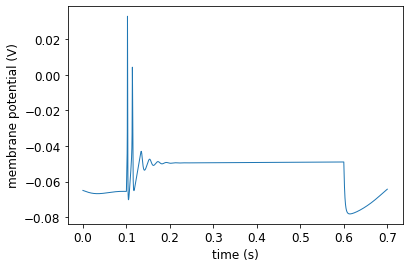

In [24]:
if __name__ == "__main__":
    main()